In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import re
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
data = pd.read_csv('amazon_alexa.tsv',delimiter='\t',quoting = 3);
print(data.shape)

(3150, 5)


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
# columns name
print(data.columns.values);

['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [6]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [8]:
data.dropna(inplace=True);

In [9]:
data['length']= data['verified_reviews'].apply(len)

In [10]:
data

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1,52
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1,137
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1,443
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1,382


In [11]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [12]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

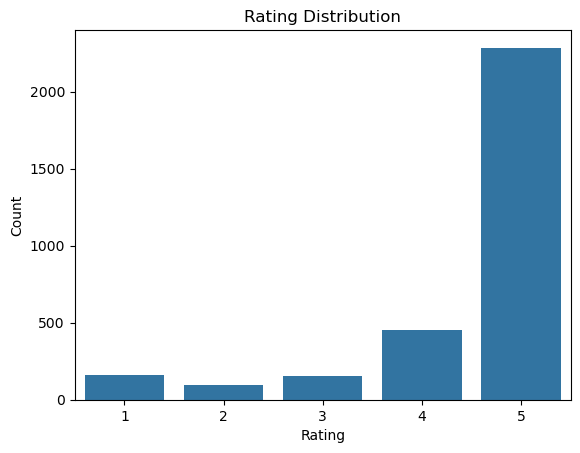

In [13]:
sns.barplot(x=data['rating'].value_counts().index, 
            y=data['rating'].value_counts().values)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()

In [14]:
# find percentage of each rating
rating_percentage = data['rating'].value_counts()/data.shape[0]*100;

<Axes: ylabel='count'>

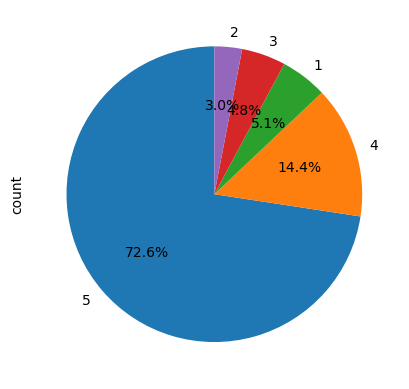

In [15]:
rating_percentage.plot.pie(autopct='%1.1f%%', startangle=90)

In [16]:
# feedback counts
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [17]:
data['feedback'].value_counts()/data.shape[0]*100

feedback
1    91.870435
0     8.129565
Name: count, dtype: float64

In [18]:
# data with feedback = 0 
data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [19]:
# data with feedback = 1 
data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [20]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

<Axes: xlabel='variation'>

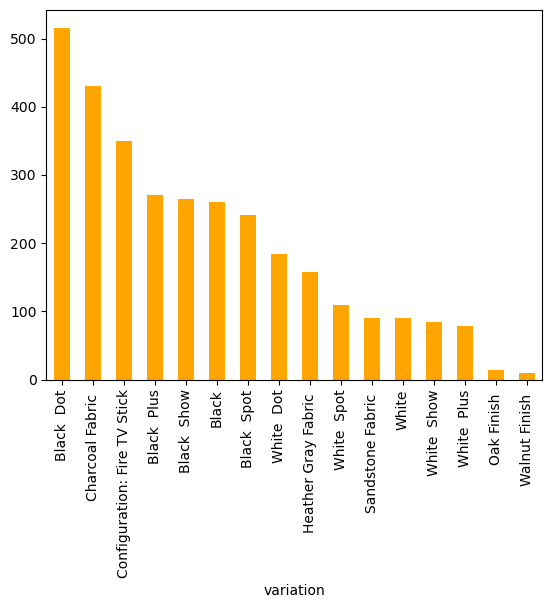

In [21]:
data['variation'].value_counts().plot.bar(color='orange')

In [22]:
# average rating of each variations
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

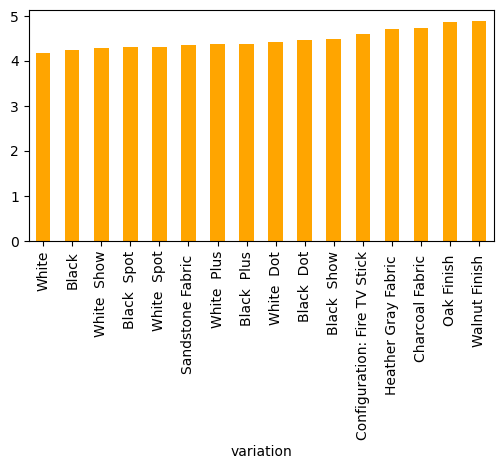

In [23]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='orange',figsize=(6,3));

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepakkishore4578/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
cv = CountVectorizer(stop_words='english');
words = cv.fit_transform(data.verified_reviews);

In [26]:
words

<3149x3784 sparse matrix of type '<class 'numpy.int64'>'
	with 33005 stored elements in Compressed Sparse Row format>

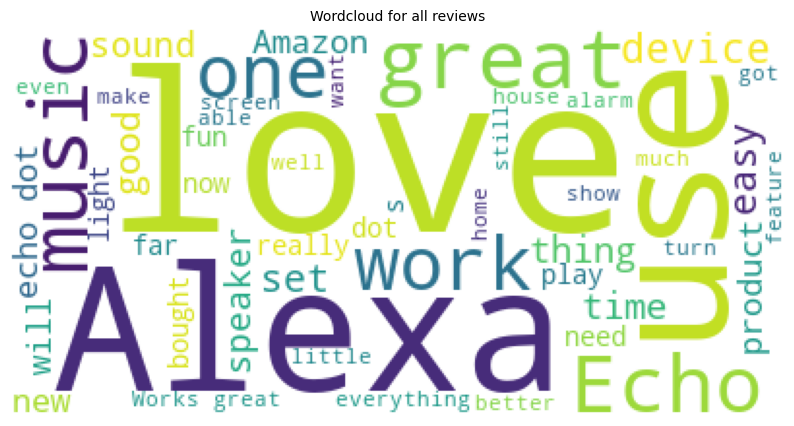

In [27]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [28]:
reviews;

In [29]:
# remove !,@,#,$ ,...
corpus =[];
sb = SnowballStemmer('english');
for i in range(0,(data.shape[0])):
    review = re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews']);
    review = review.lower().split();
    words = [sb.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review=' '.join(words)
    corpus.append(review)

In [30]:
corpus;

In [31]:
cv = CountVectorizer(max_features=2000);
X=cv.fit_transform(corpus).toarray();
X.shape

(3149, 2000)

In [32]:
y=data['feedback'].values

In [33]:
y.shape

(3149,)

# split test -train data 

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2000)
y train: (2204,)
X test: (945, 2000)
y test: (945,)


# SCALING ALL VALUES BETWEEN 0 AND 1

In [37]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

## Random forest

In [39]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [40]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9936479128856625
Testing Accuracy : 0.9417989417989417


In [41]:
y_preds = model_rf.predict(X_test_scl)
cm = confusion_matrix(y_test, y_preds)

In [42]:
cm

array([[ 29,  49],
       [  6, 861]])